In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Fri May 26 18:58:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   34C    P2    56W / 230W |   2884MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
n_fft = int(sr/fps)

### Model

In [4]:
from model.model_vqvae import Model
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs, K=16, latent_dim=128)
model = model.to(device)
print('done')

done


In [5]:
load_dir = '/data/scpark/save/lips/train05.24-2/'
!ls -lt $load_dir

path = load_dir + 'save_' + str(10000)
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

total 16310584
-rw-rw-r-- 1 scpark scpark     47422  5월 25 00:28 events.out.tfevents.1684918898.GPUSVR01
-rw-rw-r-- 1 scpark scpark 340853499  5월 25 00:27 save_48000
-rw-rw-r-- 1 scpark scpark 340853499  5월 25 00:19 save_47000
-rw-rw-r-- 1 scpark scpark 340853499  5월 25 00:11 save_46000
-rw-rw-r-- 1 scpark scpark 340853499  5월 25 00:03 save_45000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:55 save_44000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:47 save_43000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:39 save_42000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:31 save_41000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:23 save_40000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:15 save_39000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 23:07 save_38000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 22:58 save_37000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 22:50 save_36000
-rw-rw-r-- 1 scpark scpark 340853499  5월 24 22:42 save_35000
-rw-rw-r-- 1 scpark scpark 340853499  5월 

### Inference

In [6]:
import librosa

wav_file = '/Storage/RVH/w2fDataSet/a2f_data/wav/VIV_A2F_1_studios_iPhone_en.wav'
offset = 60
duration = 10
wav, _ = librosa.load(wav_file, sr=sr, offset=offset, duration=duration, res_type='polyphase')
wav = wav / max(abs(wav))
mel = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=n_fft, center=False, n_mels=n_mels)
mel = np.log10(mel + 1e-5)
mel_tensor = torch.Tensor(mel).unsqueeze(0).to(device)
print(mel.shape, mel_tensor.shape)

(8, 300) torch.Size([1, 8, 300])


c shape : torch.Size([1, 128, 300])
zi shape : torch.Size([1, 300])
zq shape : torch.Size([1, 128, 300])
y shape : torch.Size([1, 61, 300])


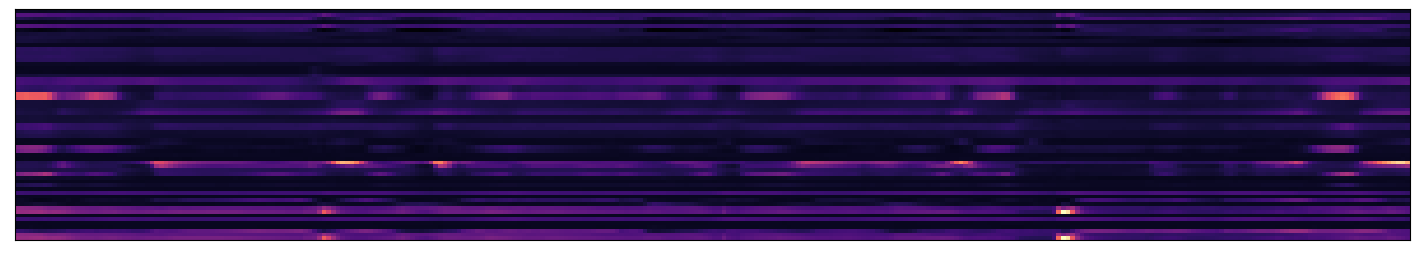

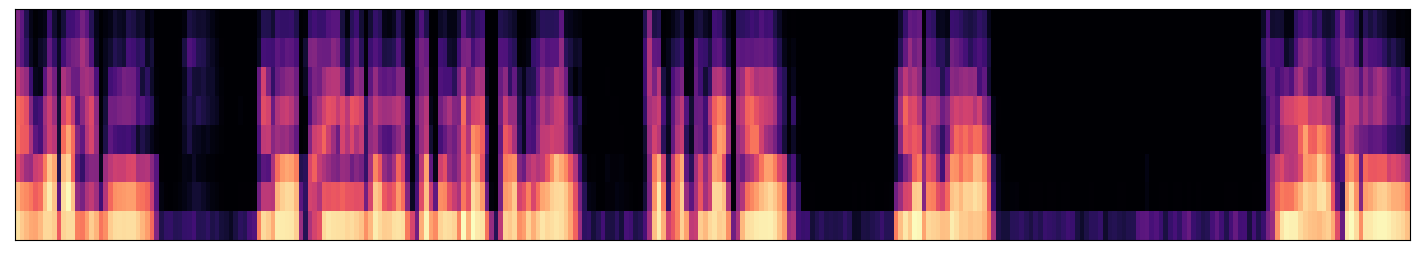

In [18]:
import librosa.display
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    pred = model.inference(mel_tensor, n_beams=20, n_depth=3)

plt.figure(figsize=[18, 3])
librosa.display.specshow(pred[0].data.cpu().numpy(), cmap='magma')
plt.show()

plt.figure(figsize=[18, 3])
librosa.display.specshow(mel_tensor[0].data.cpu().numpy(), cmap='magma')
plt.show()

In [19]:
pred.shape

torch.Size([1, 61, 300])